In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import *
from pyspark import SparkContext

In [2]:
spark = SparkSession.builder.appName("last-year-top-spending-customers").getOrCreate()

22/08/17 10:02:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
orders_df = spark.read.option("inferSchema", "True").option("header", "true") \
                      .csv("/home/jovyan/work/notebooks/ecommerce_data/olist_orders_dataset.csv")
customers_df = spark.read.option("inferSchema", "True").option("header", "true") \
                         .csv("/home/jovyan/work/notebooks/ecommerce_data/olist_customers_dataset.csv")
payments_df = spark.read.option("inferSchema", "True").option("header", "true") \
                        .csv("/home/jovyan/work/notebooks/ecommerce_data/olist_order_payments_dataset.csv")

In [13]:
orders_df.toPandas()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [15]:
orders_df.groupBy(year(col("order_purchase_timestamp"))).agg(count(year(col("order_purchase_timestamp")))).show()

+------------------------------+-------------------------------------+
|year(order_purchase_timestamp)|count(year(order_purchase_timestamp))|
+------------------------------+-------------------------------------+
|                          2018|                                54011|
|                          2016|                                  329|
|                          2017|                                45101|
+------------------------------+-------------------------------------+



In [54]:
df2 = orders_df.join(payments_df, payments_df.order_id == orders_df.order_id).drop(payments_df.order_id) \
               .join(customers_df, customers_df.customer_id == orders_df.customer_id).drop(orders_df.customer_id) \
               .filter(year("order_purchase_timestamp") == 2017).filter(month("order_purchase_timestamp") == 9) \
               .groupBy("customer_unique_id").agg(sum("payment_value")).orderBy("customer_unique_id").show()

+--------------------+------------------+
|  customer_unique_id|sum(payment_value)|
+--------------------+------------------+
|000bfa1d2f1a41876...|             46.85|
|004ad212c650c96c8...|              25.9|
|004b45ec5c6418746...|             97.87|
|005e32bc930906dc6...|              49.6|
|005ff4ebe100db3ee...|            236.81|
|006031108b00e5f73...|            204.83|
|0066b328e72fd82fd...|             94.35|
|00776f3807b128bec...|            321.57|
|007ad549acb91673f...|             90.85|
|009062f98089a0916...|             30.27|
|00970787f181925ba...|              35.4|
|00ae9ea276a5a4335...|             140.0|
|00e2972a013072289...|            215.05|
|00e5ea6932dffb682...|             68.89|
|010c88e815c838612...|            223.44|
|0116dc6ddf277eb84...|              53.7|
|0122d73327d9135f8...|              67.5|
|01290b6163d2a0251...|             96.71|
|013523c76f4749da7...|             47.82|
|0136e40591d769adf...|              58.0|
+--------------------+------------

In [49]:
last_yearx = year(col("current_timestamp")) - 5
df1 = orders_df.join(payments_df, payments_df.order_id == orders_df.order_id).drop(payments_df.order_id) \
               .join(customers_df, customers_df.customer_id == orders_df.customer_id).drop(orders_df.customer_id) \
               .groupBy(["customer_unique_id", year("order_purchase_timestamp"), month("order_purchase_timestamp")]) \
               .agg(sum("payment_value").alias("total"))

In [37]:
df1.orderBy(desc("total")).show(10)

+--------------------+------------------------------+-------------------------------+--------+
|  customer_unique_id|year(order_purchase_timestamp)|month(order_purchase_timestamp)|   total|
+--------------------+------------------------------+-------------------------------+--------+
|0a0a92112bd4c708c...|                          2017|                              9|13664.08|
|da122df9eeddfedc1...|                          2017|                              4| 7571.63|
|763c8b1c9c68a0229...|                          2018|                              7| 7274.88|
|dc4802a71eae9be1d...|                          2017|                              2| 6929.31|
|459bef486812aa252...|                          2018|                              7| 6922.21|
|ff4159b92c40ebe40...|                          2017|                              5| 6726.66|
|46450c74a0d8c5ca9...|                          2018|                              8| 6368.68|
|4007669dec559734d...|                          20

In [62]:
last_year = year(col("current_timestamp")) - 5
window = Window.partitionBy("month").orderBy(desc("total"))
df = orders_df.filter(year(col('order_purchase_timestamp')) == last_year) \
              .join(payments_df, payments_df.order_id == orders_df.order_id).drop(payments_df.order_id) \
              .join(customers_df, customers_df.customer_id == orders_df.customer_id).drop(orders_df.customer_id) \
              .groupBy(["customer_unique_id", month(col('order_purchase_timestamp')).alias("month")]) \
              .agg(sum("payment_value").alias("total")) \
              .withColumn("rank", rank().over(window)).filter(col('rank') == 1) \
              .select("customer_unique_id", "month", "total").orderBy("month")

In [63]:
df.show()

+--------------------+-----+------------------+
|  customer_unique_id|month|             total|
+--------------------+-----+------------------+
|ee2bb06c1d3f368e9...|    1|           3016.01|
|dc4802a71eae9be1d...|    2|           6929.31|
|011875f0176909c5c...|    3|           4016.91|
|da122df9eeddfedc1...|    4|           7571.63|
|ff4159b92c40ebe40...|    5|           6726.66|
|ff0ae98646e7bbb41...|    6|           3048.27|
|6172bd5b7f52ade8c...|    7|           3041.73|
|60b2ec19b8c18082c...|    8|           2692.82|
|0a0a92112bd4c708c...|    9|          13664.08|
|895617ab63a9ad888...|   10|            3126.5|
|c6111f70f40b3420e...|   10|            3126.5|
|4007669dec559734d...|   11|           6081.54|
|7a96eb0a685f5c19b...|   12|3297.3999999999996|
+--------------------+-----+------------------+



In [64]:
df.toPandas()

,customer_unique_id,month,total
0,ee2bb06c1d3f368e92084edefb7e4b57,1,3016.01
1,dc4802a71eae9be1dd28f5d788ceb526,2,6929.31
2,011875f0176909c5cf0b14a9138bb691,3,4016.91
3,da122df9eeddfedc1dc1f5349a1a690c,4,7571.63
4,ff4159b92c40ebe40454e3e6a7c35ed6,5,6726.66
5,ff0ae98646e7bbb41cf0f0d3991fef98,6,3048.27
6,6172bd5b7f52ade8c6c4548b448ff54f,7,3041.73
7,60b2ec19b8c18082cdb5180106a97cb5,8,2692.82
8,0a0a92112bd4c708ca5fde585afaa872,9,13664.08
9,c6111f70f40b3420e387493c627c27fa,10,3126.50


In [76]:
window = Window.partitionBy("month").orderBy(desc("total"))
df = orders_df.filter(year(col('order_purchase_timestamp')) == last_year) \
              .join(payments_df, payments_df.order_id == orders_df.order_id).drop(payments_df.order_id) \
              .join(customers_df, customers_df.customer_id == orders_df.customer_id).drop(orders_df.customer_id) \
              .filter(col('customer_unique_id') == "0a0a92112bd4c708ca5fde585afaa872")

In [78]:
df.toPandas()

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,03caa2c082116e1d31e67e9ae3700499,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,1,credit_card,1,13664.08,1617b1357756262bfa56ab541c47bc16,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ


NameError: name 'items_df' is not defined

In [65]:
import matplotlib.pyplot as plt

In [66]:
data = df.select('total').orderBy("month").rdd.flatMap(lambda x: x).collect()

In [67]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

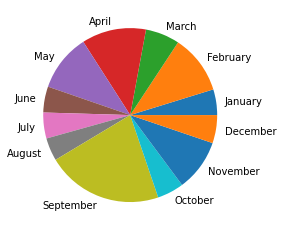

In [72]:
plt.figure()
plt.pie(data, labels=months, shadow=False)
plt.show()

In [80]:
df = orders_df.join(payments_df, payments_df.order_id == orders_df.order_id).drop(payments_df.order_id) \
              .join(customers_df, customers_df.customer_id == orders_df.customer_id).drop(orders_df.customer_id) \
              .filter(year(col('order_purchase_timestamp')) == 2017) \
              .groupBy(["customer_unique_id", month(col('order_purchase_timestamp')).alias("month")]) \
              .agg(sum("payment_value").alias("total"))

In [81]:
df.show()

+--------------------+-----+------+
|  customer_unique_id|month| total|
+--------------------+-----+------+
|e3989ce8a4e6df11d...|   12| 72.68|
|6fd9de387d337ad31...|    2| 36.77|
|f08e73cf7f4d6403e...|   11| 71.14|
|a10de9d953278e90b...|    3| 24.86|
|6d5445cddf56ea4ed...|    7| 89.17|
|fc2c474ca9fc1e074...|   12| 92.76|
|cca20bbdb16d521c1...|   11| 79.56|
|9c7bc34fa4b2fd8e3...|   11|133.24|
|9295fc2f2f8647c5b...|   12| 30.09|
|24a25a70ff5e786e8...|    4| 70.98|
|a160f2a63e7a2d7da...|    4|101.14|
|64b576fb70d441e8f...|    2|218.04|
|e578d96e5bd385142...|   12|167.53|
|252c0dcac11ce99e1...|   12| 90.46|
|784934fd0ef7f0acb...|    3| 36.89|
|8373cc590948654eb...|    9|190.37|
|79f3d6597edbdbed1...|    2|  66.9|
|6ca566e77a13d0eb5...|    9|608.87|
|bdc9d7c00e3c15045...|    3|192.56|
|3944807d83676820c...|   12|215.07|
+--------------------+-----+------+
only showing top 20 rows

